# Installing Randomer Forest (RerF)

In [3]:
# install R Randomer Forest package
# library(devtools)
# install_github("neurodata/R-RerF", subdir = "rerf")
library(rerf)

# Specify the data matrix X and class labels Y for training

  [1] setosa     setosa     setosa     setosa     setosa     setosa    
  [7] setosa     setosa     setosa     setosa     setosa     setosa    
 [13] setosa     setosa     setosa     setosa     setosa     setosa    
 [19] setosa     setosa     setosa     setosa     setosa     setosa    
 [25] setosa     setosa     setosa     setosa     setosa     setosa    
 [31] setosa     setosa     setosa     setosa     setosa     setosa    
 [37] setosa     setosa     setosa     setosa     setosa     setosa    
 [43] setosa     setosa     setosa     setosa     setosa     setosa    
 [49] setosa     setosa     versicolor versicolor versicolor versicolor
 [55] versicolor versicolor versicolor versicolor versicolor versicolor
 [61] versicolor versicolor versicolor versicolor versicolor versicolor
 [67] versicolor versicolor versicolor versicolor versicolor versicolor
 [73] versicolor versicolor versicolor versicolor versicolor versicolor
 [79] versicolor versicolor versicolor versicolor versicolor ver

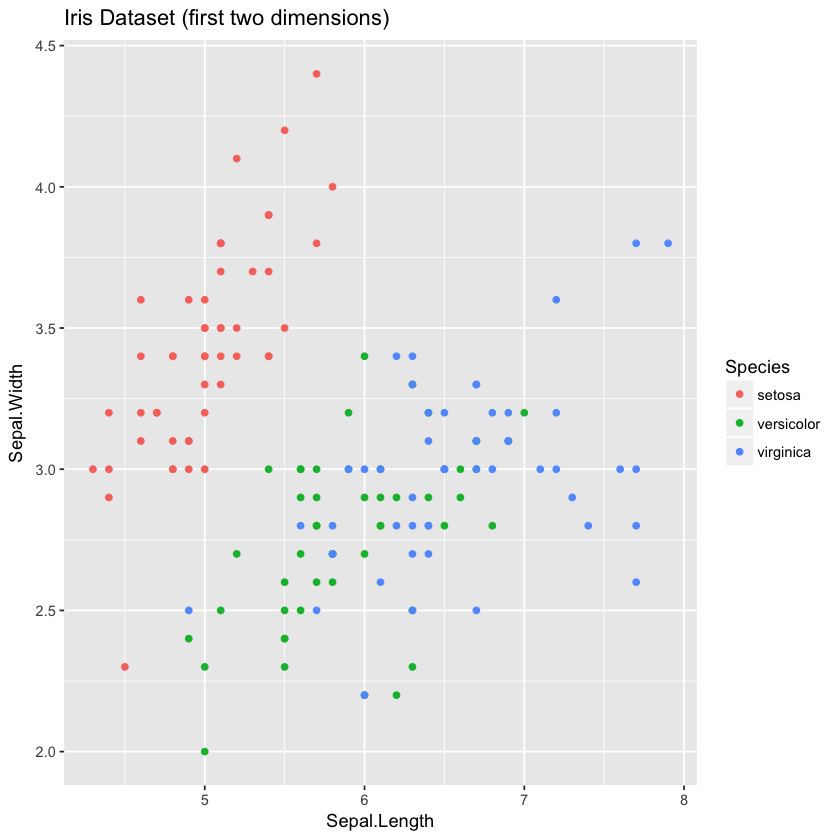

In [9]:
# we will use the iris dataset, which has 150 observations, 4 features, and 3 classes
X <- as.matrix(iris[1:4]) # can be dataframe, but a matrix is preferred
Y <- iris$Species # must be numeric (preferably integer) and between 1 and the number of classes
p <- ncol(X) # number of dimensions
num.class <- length(unique(Y)) # number of classes
seed <- 123L
print(Y)

library(ggplot2)

gghandle <- ggplot(data = iris, mapping = aes(Sepal.Length, Sepal.Width)) + geom_point(aes(colour = Species)) + 
                   ggtitle("Iris Dataset (first two dimensions)")
print(gghandle)

# Train a RerF Classifier

In [4]:
models <- vector(mode = "list", length = 2L)
# train a RerF classifier that samples one split projection per node
models[[1L]] <- RerF(X = X, Y = Y, trees = 500L, min.parent = 2L, max.depth = "inf",
               replacement = T, stratify = T, mat.options = list(p, 1L, "binary", 1/p),
               store.oob = T, num.cores = 4L, seed = seed) 

# train a RerF classifier that samples 3 split projections per node
models[[2L]] <- RerF(X = X, Y = Y, trees = 500L, min.parent = 2L, max.depth = "inf",
               replacement = T, stratify = T, mat.options = list(p, 4L, "binary", 1/p),
               store.oob = T, num.cores = 4L, seed = seed) 

# Select the better of the two models based on OOB error

In [6]:
oobError <- double(2L)

# compute oob error for first model
Yhats <- OOBPredict(X = X, forest = models[[1L]], num.cores = 4L, output.scores = F) # scores/probabilities of being in each class
oobError[1L] <- mean(Yhats != Y)
print(paste0("model 1 OOB error rate: ", sprintf("%.2f", oobError[1L]*100), "%"), quote = F)

# compute oob error for second model
Yhats <- OOBPredict(X = X, forest = models[[2L]], num.cores = 4L, output.scores = F)
oobError[2L] <- mean(Yhats != Y)
print(paste0("model 2 OOB error rate: ", sprintf("%.2f", oobError[2L]*100), "%"), quote = F)

# select the model that has the lower OOB error
bestModel <- which(oobError == min(oobError))
print(paste0("model ", bestModel, " is the better model"), quote = F)

[1] model 1 OOB error rate: 5.33%
[1] model 2 OOB error rate: 4.00%
[1] model 2 is the better model


# Compute error on a new set of observations

In [7]:
Yhats <- Predict(X = X, forest = models[[bestModel]], num.cores = 4L, output.scores = F)
mcr <- mean(Yhats != Y)
print(paste0("error rate on test set: ", sprintf("%.2f", mcr*100), "%"), quote = F)

[1] error rate on test set: 0.00%


# Demonstrate user error messages

In [10]:
RerF(X = X, Y = NULL, trees = 500L, min.parent = 2L, max.depth = "inf",
               replacement = T, stratify = T, mat.options = list(p, 1L, "binary", 1/p),
               store.oob = T, num.cores = 4L, seed = seed) 

ERROR: Error in RerF(X = X, Y = NULL, trees = 500L, min.parent = 2L, max.depth = "inf", : Incompatible data type. Y must be of type factor or numeric.


# Compute pairwise similarity between points

In [ ]:
sim <- ComputeSimilarity(X = X, forest = models[[bestModel]], num.cores = 4L)

PlotSimilarity(mtx = sim, xlabel = "", ylabel = "", title = "Iris Dataset", include_diag = T,
               legend.name = "RerF\nsimilarity", xticks = c(25, 75, 125), yticks = c(25, 75, 125),
               xticklabels = c("25" = "setosa", "75" = "versicolor", "125" = "virginica"),
               yticklabels = c("25" = "setosa", "75" = "versicolor", "125" = "virginica"))

# Using RerF with categorical data

In [ ]:
# categorical features must be one-of-K binary encoded. the categorical features must come after the numeric features
X <- as.matrix(read.table("~/tmp/uci/processed/data/audiology_std.csv", header = F, sep = ",", quote = "", row.names = NULL))

# read in the csv file that specifies how the one-of-K encoded features are grouped together
catMap <- GetCatMap("~/tmp/uci/processed/categorical_map/audiology_std_catmap.txt")

# read in the csv file that specifies a 5-fold CV partition
fold <- GetFolds("~/tmp/uci/processed/cv_partitions/audiology_std_partitions.txt")

pcat <- length(catMap)
pnum <- catMap[[1L]][1L] - 1L
p <- pcat + pnum
p.ohe <- ncol(X) - 1L
Y <- as.integer(X[, p.ohe + 1L]) + 1L
X <- X[, -(p.ohe + 1L)]
nClasses <- length(unique(Y))

mtry <- ceiling(p^(1/2))
# mtry <- ceiling(p.ohe^(1/2))
nTrees <- 500L
stratify <- T
replacement <- T
randomMatrix <- "binary"
sparsity <- 1/p
rotate <- F
MinParent <- 2L
MaxDepth <- "inf"
COOB <- T
CNS <- F
NumCores <- 4L
comp.mode <- "batch"
rank.transform <- F
  
print("training", quote = F)
start.time <- proc.time()
oob.error <- double(length(fold))
test.error <- double(length(fold))

# start 5-fold cross-validation
for (k in seq.int(length(fold))) {
  train.idx <- unlist(fold[-k])
  test.idx <- fold[[k]]
  forest <- RerF(X[train.idx, ], Y[train.idx], nClasses, min.parent = MinParent, trees = nTrees, max.depth = MaxDepth, replacement = replacement,
                 stratify = stratify, fun = RandMatCat, options = list(p, mtry, randomMatrix, sparsity, catMap), store.oob = COOB,
                 store.ns = CNS, num.cores = NumCores, seed = 123L, rotate = rotate, rank.transform = rank.transform)
  train.time <- (proc.time() - start.time)[[3]]
  print("training complete", quote = F)
  cat(paste0("elapsed time: ", train.time, " sec\n"))
  
  # compute out-of-bag predictions
  print("computing OOB error", quote = F)
  scores <- OOBPredict(X[train.idx, ], forest, NumCores)
  oob.error[k] <- mean(max.col(scores) != Y[train.idx])
  print(paste0("OOB error rate: ", sprintf("%.2f", oob.error[k]*100), "%"), quote = F) 
  
  print("computing error on held out set", quote = F)
  scores <- Predict(X[test.idx, ], forest, NumCores)
  test.error[k] <- mean(max.col(scores) != Y[test.idx])
  print(paste0("CV error rate: ", sprintf("%.2f", test.error[k]*100), "%"), quote = F)
}


# Demo for Comp-Stats meeting 09/18/2017

## RerF handles arbitrary numeric or factor class labels

In [1]:
X <- as.matrix(iris[1:4]) # can be dataframe, but a matrix is preferred
p <- ncol(X) # number of dimensions
Y <- iris$Species # Y is a factor

# print out Y
print(Y)

  [1] setosa     setosa     setosa     setosa     setosa     setosa    
  [7] setosa     setosa     setosa     setosa     setosa     setosa    
 [13] setosa     setosa     setosa     setosa     setosa     setosa    
 [19] setosa     setosa     setosa     setosa     setosa     setosa    
 [25] setosa     setosa     setosa     setosa     setosa     setosa    
 [31] setosa     setosa     setosa     setosa     setosa     setosa    
 [37] setosa     setosa     setosa     setosa     setosa     setosa    
 [43] setosa     setosa     setosa     setosa     setosa     setosa    
 [49] setosa     setosa     versicolor versicolor versicolor versicolor
 [55] versicolor versicolor versicolor versicolor versicolor versicolor
 [61] versicolor versicolor versicolor versicolor versicolor versicolor
 [67] versicolor versicolor versicolor versicolor versicolor versicolor
 [73] versicolor versicolor versicolor versicolor versicolor versicolor
 [79] versicolor versicolor versicolor versicolor versicolor ver

In [5]:
forest <- RerF(X = X, Y = Y, trees = 500L, min.parent = 2L, max.depth = "inf",
               replacement = T, stratify = T, mat.options = list(p, 4L, "binary", 1/p),
               store.oob = T, num.cores = 4L, seed = 123L)

## Rather than passing forest parameters manually into downstream functions, the forest now stores the parameters it was trained with and are read internally by the functions

### For example, previously OOBPredict and Predict required the user to set a flag "rank.transform", which let the functions know whether or not the forest had been trained on data that had been passed to ranks. Now the forest stores the flag, and OOBPredict and Predict check whether this flag is TRUE or False internally.

In [6]:
# Print out the params field
print(forest$params)

$min.parent
[1] 2

$max.depth
[1] "inf"

$bagging
[1] 0.2

$replacement
[1] TRUE

$stratify
[1] TRUE

$fun
function (mat.options) 
{
    p <- mat.options[[1L]]
    d <- mat.options[[2L]]
    method <- mat.options[[3L]]
    if (method == "binary") {
        rho <- mat.options[[4L]]
        nnzs <- round(p * d * rho)
        ind <- sort(sample.int((p * d), nnzs, replace = F))
        random.matrix <- cbind(((ind - 1L)%%p) + 1L, floor((ind - 
            1L)/p) + 1L, sample(c(1L, -1L), nnzs, replace = T))
    }
    else if (method == "continuous") {
        rho <- mat.options[[4L]]
        nnzs <- round(p * d * rho)
        ind <- sort(sample.int((p * d), nnzs, replace = F))
        random.matrix <- cbind(((ind - 1L)%%p) + 1L, floor((ind - 
            1L)/p) + 1L, zrnorm(nnzs))
    }
    else if (method == "rf") {
        random.matrix <- cbind(sample.int(p, d, replace = F), 
            1:d, rep(1L, d))
    }
    else if (method == "poisson") {
        lambda <- mat.options[[4L]]
      

## OOBPredict and Predict now have the options of returning either the class labels or the class posteriors

In [7]:
# Return predicted class labels and print
Yhats <- OOBPredict(X, forest, num.cores = 1L)
print(Yhats)

  [1] setosa     setosa     setosa     setosa     setosa     setosa    
  [7] setosa     setosa     setosa     setosa     setosa     setosa    
 [13] setosa     setosa     setosa     setosa     setosa     setosa    
 [19] setosa     setosa     setosa     setosa     setosa     setosa    
 [25] setosa     setosa     setosa     setosa     setosa     setosa    
 [31] setosa     setosa     setosa     setosa     setosa     setosa    
 [37] setosa     setosa     setosa     setosa     setosa     setosa    
 [43] setosa     setosa     setosa     setosa     setosa     setosa    
 [49] setosa     setosa     versicolor versicolor versicolor versicolor
 [55] versicolor versicolor versicolor versicolor versicolor versicolor
 [61] versicolor versicolor versicolor versicolor versicolor versicolor
 [67] versicolor versicolor versicolor versicolor virginica  versicolor
 [73] versicolor versicolor versicolor versicolor versicolor virginica 
 [79] versicolor versicolor versicolor versicolor versicolor vir

In [9]:
# return predicted class posteriors instead by setting the "output.scores" flag to TRUE
scores <- OOBPredict(X, forest, num.cores = 1L, output.scores = T)
colnames(scores) <- levels(Y)
print(scores)

            setosa  versicolor   virginica
  [1,] 1.000000000 0.000000000 0.000000000
  [2,] 1.000000000 0.000000000 0.000000000
  [3,] 1.000000000 0.000000000 0.000000000
  [4,] 1.000000000 0.000000000 0.000000000
  [5,] 1.000000000 0.000000000 0.000000000
  [6,] 1.000000000 0.000000000 0.000000000
  [7,] 1.000000000 0.000000000 0.000000000
  [8,] 1.000000000 0.000000000 0.000000000
  [9,] 0.995098039 0.004901961 0.000000000
 [10,] 1.000000000 0.000000000 0.000000000
 [11,] 1.000000000 0.000000000 0.000000000
 [12,] 1.000000000 0.000000000 0.000000000
 [13,] 1.000000000 0.000000000 0.000000000
 [14,] 1.000000000 0.000000000 0.000000000
 [15,] 0.979057592 0.020942408 0.000000000
 [16,] 0.968085106 0.026595745 0.005319149
 [17,] 1.000000000 0.000000000 0.000000000
 [18,] 1.000000000 0.000000000 0.000000000
 [19,] 0.988888889 0.011111111 0.000000000
 [20,] 1.000000000 0.000000000 0.000000000
 [21,] 1.000000000 0.000000000 0.000000000
 [22,] 1.000000000 0.000000000 0.000000000
 [23,] 1.00

## All functions have documentation, which can be viewed using the standard "?FunctionName" syntax

In [14]:
# print out help for RerF
hs <- capture.output(tools:::Rd2txt("~/R-RerF/rerf/man/RerF.Rd"))
cat(hs, sep = "\n")

_R_e_r_F _f_o_r_e_s_t _G_e_n_e_r_a_t_o_r

_D_e_s_c_r_i_p_t_i_o_n:

     Creates a decision forest based on an input matrix and class
     vector.  This is the main function in the rerf package.

_U_s_a_g_e:

     RerF(X, Y, min.parent = 6L, trees = 100L, max.depth = 0L, bagging = 0.2,
       replacement = TRUE, stratify = FALSE, fun = NULL, mat.options = list(p
       = ncol(X), d = ceiling(sqrt(ncol(X))), random.matrix = "binary", rho =
       1/ncol(X)), rank.transform = FALSE, store.oob = FALSE, store.ns = FALSE,
       progress = FALSE, rotate = F, num.cores = 0L, seed = 1L,
       cat.map.file = NULL)
     
_A_r_g_u_m_e_n_t_s:

       X: an n by d numeric matrix (preferable) or data frame. The rows
          correspond to observations and columns correspond to
          features.

       Y: an n length vector of class labels.  Class labels must be
          integer or numeric and be within the range 1 to the number of
          classes.


In [15]:
# print out help for OOBPredict
hs <- capture.output(tools:::Rd2txt("~/R-RerF/rerf/man/OOBPredict.Rd"))
cat(hs, sep = "\n")

_C_o_m_p_u_t_e _o_u_t-_o_f-_b_a_g _p_r_e_d_i_c_t_i_o_n_s

_D_e_s_c_r_i_p_t_i_o_n:

     Computes out-of-bag class predictions for a forest trained with
     store.oob=TRUE.

_U_s_a_g_e:

     OOBPredict(X, forest, num.cores = 0L, output.scores = FALSE)
     
_A_r_g_u_m_e_n_t_s:

       X: an n sample by d feature matrix (preferable) or data frame
          which was used to train the provided forest.

  forest: a forest trained using the RerF function, with
          store.oob=TRUE.

num.cores: the number of cores to use while training. If num.cores=0
          then 1 less than the number of cores reported by the OS are
          used. (num.cores=0)

output.scores: if TRUE then predicted class scores (probabilities) for
          each observation are returned rather than class labels.
          (output.scores = FALSE)

_V_a_l_u_e:

     predictions

_A_u_t_h_o_r(_s):

     James and Tyler, jbrowne6@jhu.edu and ttomita2@jhmi

In [16]:
# print out help for Predict
hs <- capture.output(tools:::Rd2txt("~/R-RerF/rerf/man/Predict.Rd"))
cat(hs, sep = "\n")

_C_o_m_p_u_t_e _c_l_a_s_s _p_r_e_d_i_c_t_i_o_n_s _f_o_r _e_a_c_h _o_b_s_e_r_v_a_t_i_o_n _i_n _X

_D_e_s_c_r_i_p_t_i_o_n:

     Predicts the classification of samples using a trained forest.

_U_s_a_g_e:

     Predict(X, forest, num.cores = 0L, Xtrain = NULL, aggregate.output = TRUE,
       output.scores = FALSE)
     
_A_r_g_u_m_e_n_t_s:

       X: an n by d numeric matrix (preferable) or data frame. The rows
          correspond to observations and columns correspond to features
          of a test set, which should be different from the training
          set.

  forest: a forest trained using the RerF function.

num.cores: the number of cores to use while training. If NumCores=0
          then 1 less than the number of cores reported by the OS are
          used. (NumCores=0)

  Xtrain: an n by d numeric matrix (preferable) or data frame. This
          should be the same data matrix/frame used to train the
       

In [17]:
# print out help for ComputeSimilarity
hs <- capture.output(tools:::Rd2txt("~/R-RerF/rerf/man/ComputeSimilarity.Rd"))
cat(hs, sep = "\n")

_C_o_m_p_u_t_e _S_i_m_i_l_a_r_i_t_i_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Computes pairwise similarities between observations. The
     similarity between two points is defined as the fraction of trees
     such that two points fall into the same leaf node.

_U_s_a_g_e:

     ComputeSimilarity(X, forest, num.cores = 0L, Xtrain = NULL)
     
_A_r_g_u_m_e_n_t_s:

       X: an n sample by d feature matrix (preferable) or data frame
          which was used to train the provided forest.

  forest: a forest trained using the rerf function, with COOB=TRUE.

num.cores: the number of cores to use while training. If num.cores=0
          then 1 less than the number of cores reported by the OS are
          used. (num.cores=0)

  Xtrain: an n by d numeric matrix (preferable) or data frame. This
          should be the same data matrix/frame used to train the
          forest, and is only required if RerF was called with
          rank.transform = TRUE. (X

In [18]:
# print out help for StrCorr
hs <- capture.output(tools:::Rd2txt("~/R-RerF/rerf/man/StrCorr.Rd"))
cat(hs, sep = "\n")

_C_o_m_p_u_t_e _t_r_e_e _s_t_r_e_n_g_t_h _a_n_d _c_o_r_r_e_l_a_t_i_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     Computes estimates of tree strength and correlation according to
     the definitions in Breiman's 2001 Random Forests paper.

_U_s_a_g_e:

     StrCorr(Yhats, Y)
     
_A_r_g_u_m_e_n_t_s:

   Yhats: predicted class labels for each tree in a forest.

       Y: true class labels.

_V_a_l_u_e:

     scor

_A_u_t_h_o_r(_s):

     James and Tyler, jbrowne6@jhu.edu and

_E_x_a_m_p_l_e_s:

     library(rerf)
     trainIdx <- c(1:40, 51:90, 101:140)
     X <- as.matrix(iris[,1:4])
     Y <- iris[[5]]
     forest <- RerF(X[trainIdx, ], Y[trainIdx], num.cores = 1L)
     predictions <- Predict(X[-trainIdx, ], forest, num.cores = 1L, aggregate.output = FALSE)
     scor <- StrCorr(predictions, Y[-trainIdx])
     
